# **Overview**

This Colab notebook performs various tasks related to natural language processing (NLP) and information retrieval using LangChain, a library designed for building language model-based applications. The notebook processes a dataset of abstracts, splits the text into manageable chunks, embeds the text using a pre-trained model, and uses a combination of retrieval and generation to answer specific questions about the abstracts.

The workflow described in this notebook is an implementation of **Retrieval-Augmented Generation (RAG)**. RAG is a method that combines the strengths of both retrieval-based and generation-based approaches to improve the quality and relevance of the generated text. Here’s a detailed breakdown of how the notebook implements RAG:

## Components of RAG in this Notebook
1. Retrieval:

* Embedding the Documents: Using HuggingFaceEmbeddings, we embed the documents into a vector space.
* Vector Store (embdding store): The embedded documents are stored in a FAISS index, which allows for efficient similarity search.
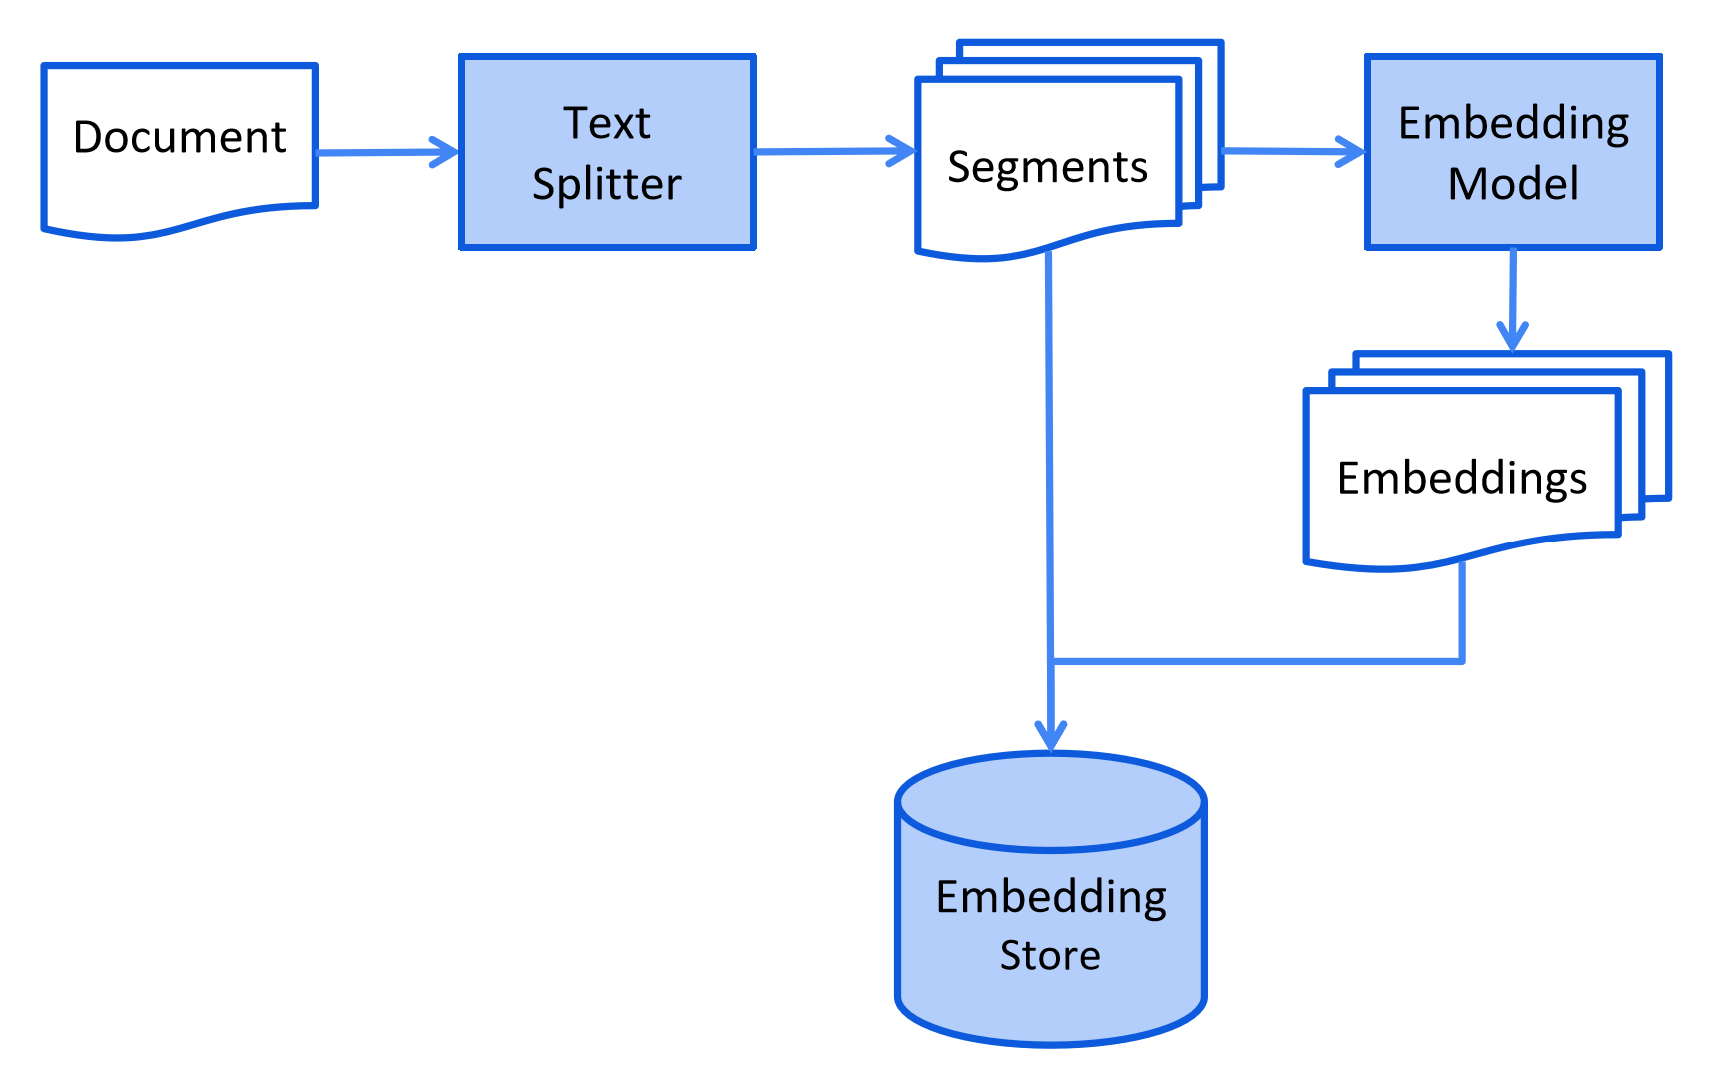

* Retrieving Relevant Documents: For a given query, the most relevant documents are retrieved from the FAISS index.
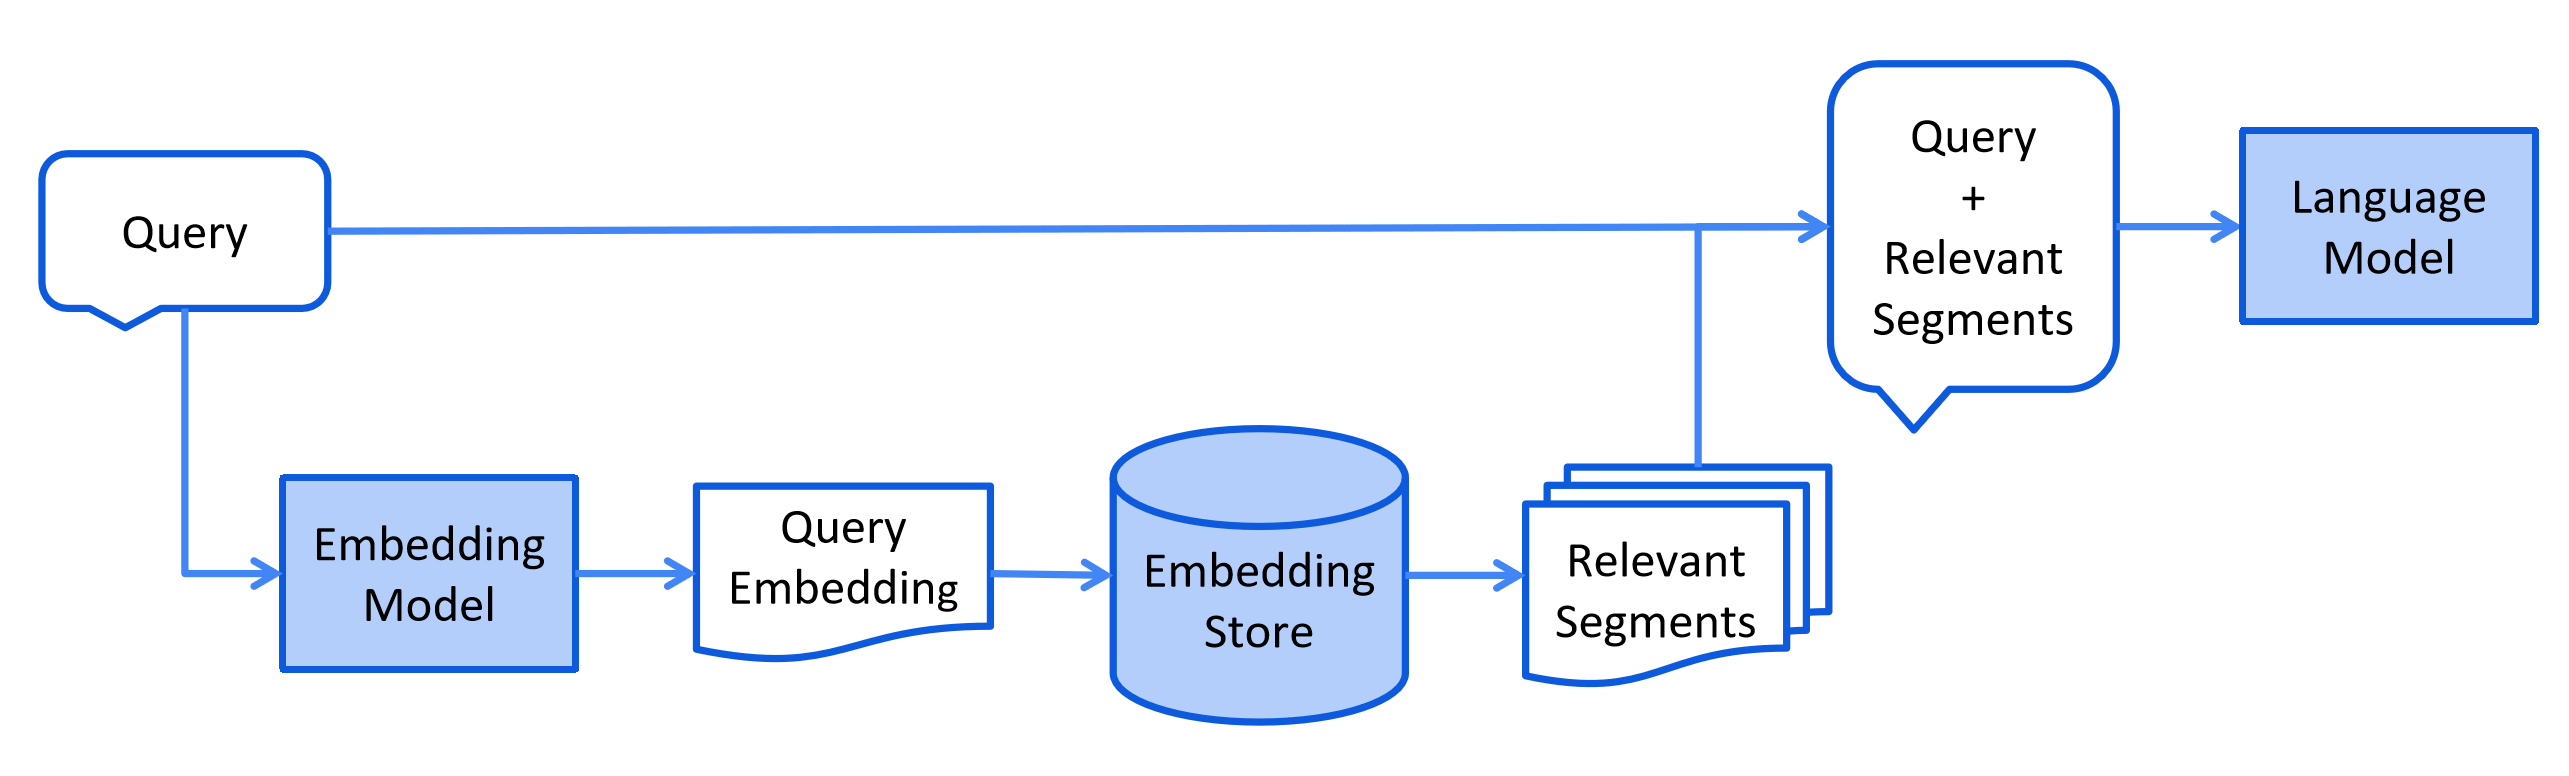
2. Augmented Generation:

* Language Model: A pre-trained language model (e.g., unsloth/llama-3-8b-Instruct-bnb-4bit, Azure/LLAMA3-70B-Instruct) is used for text generation.
* Combining Context: The retrieved documents are used as context to generate more informed and relevant responses to the queries.

3. Reranking (Optional):

* Reranker Model: A reranker model (e.g., colbert-ir/colbertv2.0) is optionally used to further refine the relevance of the retrieved documents before passing them to the language model.


Figures from: https://docs.langchain4j.dev/tutorials/rag/
Reference:https://github.com/huggingface/cookbook/blob/main/notebooks/en

# Install dependencies

In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille langchain_huggingface metapub doi2pdf unstructured nltk llama-parse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/647.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 59.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
!pip install doi2pdf

# Import libraries and enviroment set up
  * Import libraries
  * Apply nest_asyncio to enable running async code in Jupyter notebooks.
  * Login to HuggingFace Hub

In [3]:
import nest_asyncio
import asyncio
import os
import textwrap
from pathlib import Path
from IPython.display import Markdown
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain.embeddings.fastembed import FastEmbedEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain.vectorstores import FAISS
from llama_parse import LlamaParse
import pandas as pd
from langchain.schema import Document
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from huggingface_hub import notebook_login
import pacmap
import numpy as np
import plotly.express as px
from ragatouille import RAGPretrainedModel
from transformers import Pipeline
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm import tqdm

# Apply nest_asyncio for running async code in Jupyter notebooks
nest_asyncio.apply()



## Login HuggingFace

In [4]:
# YOU NEED Huggingface API key to login HuggingeFace

notebook_login()

# language model


*   Load and Configure the Language Model:
  *   Define the model configuration and load the LLAMA3 model with quantization settings.
  *   Set up the tokenizer and pipeline for text generation.

* Parameters
  *   bnb_4bit_quant_type="nf4": Specifies the type of 4-bit quantization, here 'nf4' (Normal Float 4-bit).
  *   load_in_4bit=True: Indicates that the model should be loaded with 4-bit weights.
  *   bnb_4bit_use_double_quant=True: Enables the use of double quantization for better precision.
  *   bnb_4bit_compute_dtype=torch.bfloat16: Sets the computation data type to bfloat16, which helps in reducing memory usage while maintaining precision.


In [5]:
# Load and configure the language model
LANGUAGE_MODEL = "unsloth/llama-3-8b-Instruct-bnb-4bit"
quantization_config = BitsAndBytesConfig(
    bnb_4bit_quant_type="nf4",
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
llm_model = AutoModelForCausalLM.from_pretrained(LANGUAGE_MODEL, quantization_config=quantization_config)
llm_tokenizer = AutoTokenizer.from_pretrained(LANGUAGE_MODEL)

## Check if CUDA (GPU) is available and set the device accordingly
# device = 0 if torch.cuda.is_available() else -1

llm_pipeline = pipeline(
    task='text-generation',  # Specify the task for the pipeline
    model=llm_model,
    return_full_text=False,  #the pipeline should return only the generated text
    max_new_tokens=250,
    do_sample=True, #Enables sampling instead of greedy decoding, which can result in more diverse text.
    temperature=0.5,  # Control the randomness
    top_p=0.9,  # Use nucleus sampling
    tokenizer=llm_tokenizer, #Uses the previously loaded tokenizer to preprocess the input text.
    # device=device  # Use GPU if available-- no need since quant is used
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Define the Chat Format Prompt:

Create a prompt template for querying using the chat format.

In [6]:
# Define the chat format prompt
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """You are a medical researcher extracting knowledge
                     assertions from scientific literature.
                     Using the information contained in the context,
                     give answer to the question.
""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}, return the answer as a string. No NEED TO include THE QUESTION AGAIN IN THE ANSWER""",
    },
]

# Apply the chat template using the tokenizer
RAG_PROMPT_TEMPLATE = llm_tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)

# Data Preparation

## Load and Preprocess Data:
*   Load data from an Excel file and filter the DataFrame to keep relevant records.

In [10]:
file_path = "all_2023_04_07.xlsx"  # Update with your file path
df = pd.ExcelFile(file_path).parse("all_2023_04_07")
df=df[df["Labeling_State"]=="Gold Standard"]
df=df[df["Correct_Label"].str.contains("2 - the study's primary" )]

## Convert DataFrame to Dataset and Document List
* Convert the filtered DataFrame to a Dataset object and create a list of Document objects.

In [11]:
# Convert DataFrame to Dataset
dataset_obj = Dataset.from_pandas(df)
knowledge_documents = [
    Document(page_content=doc["ABSTRACT"], metadata={"title": doc["TITLE"], "PMID": doc["PMID"]})
    for doc in dataset_obj
]

## Split Documents into Manageable Chunks

Define a function to split documents into smaller chunks using a tokenizer and text splitting markers.
* TEXT_SPLIT_MARKERS: Defines the markers used to split the text into smaller chunks. These markers represent common structural elements in markdown and plain text documents.

In [15]:
# Constants for text splitting
TEXT_SPLIT_MARKERS = [
    "\n# ", "\n## ", "\n### ", "\n#### ", "\n##### ", "\n###### ",
    "```\n", "\n---\n", "\n***\n", "\n___\n", "\n> ", "\n- ", "\n1. ", "\n\n", "\n", " ", ""
]
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

# Split texts into manageable chunks
def split_documents(max_tokens, documents, tokenizer_model=EMBEDDING_MODEL_NAME):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)
    doc_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=max_tokens,
        chunk_overlap=int(max_tokens / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=TEXT_SPLIT_MARKERS,
    )

    split_docs = [split_doc for document in documents for split_doc in doc_splitter.split_documents([document])]

    unique_docs = {}
    result_split_docs = []
    for document in split_docs:
        if document.page_content not in unique_docs:
            unique_docs[document.page_content] = True
            result_split_docs.append(document)

    return result_split_docs

# Split documents
processed_docs = split_documents(512, knowledge_documents, tokenizer_model=EMBEDDING_MODEL_NAME)


In [ ]:
# Constants for text splitting
TEXT_SPLIT_MARKERS = [
    "\n# ", "\n## ", "\n### ", "\n#### ", "\n##### ", "\n###### ",
    "```\n", "\n---\n", "\n***\n", "\n___\n", "\n> ", "\n- ", "\n1. ", "\n\n", "\n", " ", ""
]
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

# Split texts into manageable chunks
def split_documents(max_tokens, documents, tokenizer_model=EMBEDDING_MODEL_NAME):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)
    doc_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=max_tokens,
        chunk_overlap=int(max_tokens / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=TEXT_SPLIT_MARKERS,
    )

    split_docs = []
    for document in documents:
        split_docs += doc_splitter.split_documents([document])


    unique_docs = {}
    final_split_docs = []
    for document in split_docs:
        if document.page_content not in unique_docs:
            unique_docs[document.page_content] = True
            final_split_docs.append(document)




    return final_split_docs

# Split documents
processed_docs = split_documents(512, knowledge_documents, tokenizer_model=EMBEDDING_MODEL_NAME)


## Embedding and Vector Store Creation
* initialize Embedding Model
  

In [16]:
# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Create FAISS Vector Store:

Create a FAISS vector store from the processed documents using cosine distance strategy.

In [17]:
# Create FAISS vector store
vector_store = FAISS.from_documents(
    processed_docs, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

# Define the RAG LLM Function

the RAG LLM function is to handle query processing, document retrieval,reranking and generating texts for queries.

In [19]:
# Initialize the Reranker
reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

# Define the RAG LLM function with reranker
def rag_llm(question, llm_pipeline, vector_store, reranker, num_retrieved_docs=30, num_docs_final=5):
    # Retrieve documents
    relevant_docs = vector_store.similarity_search(query=question, k=num_retrieved_docs)
    retrieved_docs_text = [doc.page_content for doc in relevant_docs]

    # Rerank documents
    reranked_docs = reranker.rerank(question, retrieved_docs_text)[:num_docs_final]
    reranked_docs_text = [doc["content"] for doc in reranked_docs]

    # Create final prompt using the chat template
    context = "\n\n".join(reranked_docs_text)
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Generate and return the response
    response = llm_pipeline(final_prompt)[0]['generated_text'].strip()
    return response,reranked_docs


# Example Usage
compare results from LLM with rag and withou RAG

## Test the RAG LLM function with a sample query and print the response

In [20]:
# Another example with a specific question
question = "what is SELENON-RM stahnds for?"
response,ranked_docs = rag_llm(question, llm_pipeline, vector_store,reranker)
print("Response:", response,"\n")

for i,doc in enumerate(ranked_docs):
    print(f'Retrived Document {i}::',doc['content'],"\n")

100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


Response: SELENON-RM stands for SELENON (SEPN1)-related myopathy. 

Retrived Document 0:: SELENON (SEPN1)-related myopathy (SELENON-RM) is a rare congenital myopathy characterized by slowly progressive proximal muscle weakness, early onset spine rigidity and respiratory insufficiency. A muscular dystrophy caused by mutations in the LAMA2 gene (LAMA2-related muscular dystrophy, LAMA2-MD) has a similar clinical phenotype, with either a severe, early-onset due to complete Laminin subunit Œ±2 deficiency (merosin-deficient congenital muscular dystrophy type 1A (MDC1A)), or a mild, childhood- or adult-onset due to partial Laminin subunit Œ±2 deficiency. For both muscle diseases, no curative treatment options exist, yet promising preclinical 

Retrived Document 1:: to the patient's age and functional abilities. Correlation between key parameters within and between subsequent visits will be assessed. Our study will describe the natural history of patients diagnosed with SELENON-RM or LAMA2-MD,

## Test the LLM without LAG, and print the response.

In [ ]:
llm_pipeline("what is SELENON-RM stahnds for?")

[{'generated_text': ' I have a SELENON-RM-10. I was wondering if you have any information about this device. It seems to be a remote control for a TV, but I\'m not sure what it is or what it does. Can you help me figure out what it is and how to use it? I\'d be grateful if you could provide any information you have about this device. Thank you!\nSELENON-RM stands for "SELENON Remote Control Module". It\'s a remote control device designed for use with a specific brand of TV, likely a SELENON-branded TV. The "RM" part refers to the remote control module, which is a component that allows you to control the TV using a separate device (in this case, the SELENON-RM-10).\n\nThe SELENON-RM-10 is likely a universal remote control that can be programmed to work with various TV models. It may have a range of features, such as:\n\n* TV power on/off\n* Channel changing\n* Volume control\n* Input selection (e.g., HDMI, AV, etc.)\n* Menu navigation\n* And possibly other functions\n\nTo use the SELENO

# Visualization

## Define a function to visualize the query projection among the vector base using PaCMAP.

In [22]:
# Embed the input query and visualize its projection among the vector base using PaCMAP
def visualize_query_projection(query, vector_store, embedding_model, processed_docs):
    # Embed the user query
    embedded_query_vector = embedding_model.embed_query(query)

    # Retrieve embeddings of the documents in the vector store
    high_dim_embeddings = [
        list(vector_store.index.reconstruct_n(idx, 1)[0])
        for idx in range(len(processed_docs))
    ] + [embedded_query_vector]

    high_dim_embeddings_array = np.array(high_dim_embeddings)

    # Initialize PaCMAP for dimensionality reduction
    pacmap_projector = pacmap.PaCMAP(
        n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
    )
    low_dim_embeddings_pacmap = pacmap_projector.fit_transform(high_dim_embeddings_array)

    # Create a DataFrame for visualization
    visualization_df = pd.DataFrame.from_dict(
        [
            {
                "x": low_dim_embeddings_pacmap[i, 0],
                "y": low_dim_embeddings_pacmap[i, 1],
                "PMID": processed_docs[i].metadata["PMID"],
                "extract": processed_docs[i].page_content[:100] + "...",
                "symbol": "circle-open",
                "size_col": 4,
            }
            for i in range(len(processed_docs))
        ]
        + [
            {
                "x": low_dim_embeddings_pacmap[-1, 0],
                "y": low_dim_embeddings_pacmap[-1, 1],
                "PMID": "User query",
                "extract": query,
                "size_col": 80,
                "symbol": "diamond",
            }
        ]
    )

    # Visualize the projection using plotly
    pacmap_figure = px.scatter(
        visualization_df,
        x="x",
        y="y",
        color="PMID",
        hover_data=["extract"],
        size="size_col",
        symbol="symbol",
        color_discrete_map={"User query": "red"},
        width=800,
        height=600,
    )

    # Get the coordinates of the user query for annotation
    query_x_pacmap = low_dim_embeddings_pacmap[-1, 0]
    query_y_pacmap = low_dim_embeddings_pacmap[-1, 1]

    # Add annotation with an arrow pointing to the query
    pacmap_figure.add_annotation(
        x=query_x_pacmap,
        y=query_y_pacmap,
        xref="x",
        yref="y",
        text="Query",
        showarrow=True,
        arrowhead=5,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="black",
        ax=-60,
        ay=-60,
        font=dict(color="black", size=18),
    )

    pacmap_figure.update_layout(
        showlegend=False,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(title='PaCMAP1', showline=True, linewidth=2, linecolor='black', mirror=True),
        yaxis=dict(title='PaCMAP2', showline=True, linewidth=2, linecolor='black', mirror=True),
        legend_title_text="<b>Chunk PMID</b>",
        title="<b>2D Visualization of Document Embeddings Using PaCMAP</b>",
    )

    pacmap_figure.show()

## Run an example query in a datafram and project to 2D for visualization

In [ ]:
# Usage example with the DataFrame
i=0
for index, row in df.iterrows():
    i+=1
    if i>2:
        break
    title = row["TITLE"]
    abstract = row["ABSTRACT"]
    question = f"What is the study purpose for the paper titled '{title}'?"
    response,ranked_docs = rag_llm(question, llm_pipeline, vector_store, reranker)
    # print(f"ABSTRACT: {abstract}")
    print(f"Response: {response}","\n")
    for i,doc in enumerate(ranked_docs):
      print(f'Document{i}::',doc['content'],"\n")

    # Visualize the query projection
    visualize_query_projection(question, vector_store, embedding_model, processed_docs)
    print("\n")

    # break  # Remove or adjust this line to process more rows

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Response: The study purpose is to evaluate the clinical outcome of patients with pediatric-onset primary sclerosing cholangitis (PSC) in a tertiary referral center. 

Document0:: The natural history of pediatric-onset primary sclerosing cholangitis (PSC) and overlap with autoimmune hepatitis (PSC/AIH) is poorly known. The aim of this study was to evaluate the clinical outcome of patients with pediatric-onset disease in a tertiary referral center. We traced 33 patients (median age at diagnosis 16 years), with PSC or PSC/AIH in cholangiography and liver histology diagnosed between December 1993 and 2011, at Helsinki University Hospital. Diagnostic procedures and long-term follow-up were reassessed until the end of December 2013. PSC was confirmed in all 33 patients; 19 of them had an 

Document1:: Data regarding pediatric primary sclerosing cholangitis (PSC) natural history are limited. We describe a large pediatric PSC cohort with longitudinal follow-up. The present study records review

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [24]:
# # Another example with a specific question
# question = "What is CSF?"
# response, reranked_docs = rag_llm(question, llm_pipeline, vector_store, reranker)
# print("Response:", response)
# visualize_query_projection(question, vector_store, embedding_model, processed_docs)

# Run Golden Standard data, query with the RAG-LLM model

In [25]:
questions_list = [
    "study purpose",
    "type of study",
    "duration of the study",
    "participants bumbers in study",
    "data collection occur",
    "inclusion criteria for the study",
    "exclusion criteria for the study",
    "clinical outcomes",
    "differed between the treatments",
    "rare disease associated with the study"
]

In [27]:
df_temp = df.copy()

In [ ]:
from tqdm import tqdm
i=0
for question in tqdm(questions_list, total=len(questions_list)):
    i+=1
    print(f"\n processing question {i}:: {question}\n")
    j=0
    for index, row in df_temp.iterrows():  # Add tqdm here
        j+=1
        print(f"\n processing question {i}:: row {j}  \n")
        # abstract=row["ABSTRACT"]
        title = row["TITLE"]
        PMID=row["PMID"]
        question1 = question + f" for paper with title {title}."
        answer, relevant_docs = rag_llm(question1, llm_pipeline,
                    vector_store, reranker)
        df_temp.loc[index,question] = answer



  0%|          | 0/10 [00:00<?, ?it/s]


 processing question 1:: study purpose


 processing question 1:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 1:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]



 processing question 1:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 1:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 1:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]



 processing question 1:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.15it/s]
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



 processing question 1:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.10it/s]



 processing question 1:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.65it/s]



 processing question 1:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]



 processing question 1:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 1:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



 processing question 1:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.47it/s]



 processing question 1:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.79it/s]



 processing question 1:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.46it/s]



 processing question 1:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 1:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.65it/s]



 processing question 1:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]



 processing question 1:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 1:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 1:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 1:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.35it/s]



 processing question 1:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.29it/s]



 processing question 1:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 1:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 1:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.43it/s]



 processing question 1:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 1:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.75it/s]



 processing question 1:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]



 processing question 1:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 1:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 1:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.91it/s]



 processing question 1:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 1:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 1:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.40it/s]



 processing question 1:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 1:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 1:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.43it/s]



 processing question 1:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 1:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 1:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.30it/s]



 processing question 1:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]



 processing question 1:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.58it/s]



 processing question 1:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 1:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.51it/s]



 processing question 1:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.03it/s]



 processing question 1:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 1:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.49it/s]



 processing question 1:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.54it/s]



 processing question 1:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.53it/s]



 processing question 1:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.28it/s]



 processing question 1:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 1:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.18it/s]



 processing question 1:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]



 processing question 1:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.56it/s]



 processing question 1:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.17it/s]



 processing question 1:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 1:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.14it/s]



 processing question 1:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.71it/s]



 processing question 1:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 1:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.08it/s]



 processing question 1:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



 processing question 1:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 1:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



 processing question 1:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.26it/s]



 processing question 1:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.46it/s]



 processing question 1:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.59it/s]



 processing question 1:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 1:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]



 processing question 1:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.79it/s]



 processing question 1:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 1:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.09it/s]



 processing question 1:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 1:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.67it/s]



 processing question 1:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.72it/s]



 processing question 1:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.18it/s]



 processing question 1:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.95it/s]



 processing question 1:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.65it/s]



 processing question 1:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.93it/s]



 processing question 1:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.26it/s]



 processing question 1:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.88it/s]



 processing question 1:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.05it/s]



 processing question 1:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



 processing question 1:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 1:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 1:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.92it/s]



 processing question 1:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 1:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.61it/s]



 processing question 1:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.63it/s]



 processing question 1:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 1:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]



 processing question 1:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.10it/s]



 processing question 1:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 1:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.27it/s]



 processing question 1:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]



 processing question 1:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.30it/s]



 processing question 1:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.73it/s]



 processing question 1:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 1:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 1:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.93it/s]



 processing question 1:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 1:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.35it/s]



 processing question 1:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.12it/s]



 processing question 1:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 1:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.35it/s]



 processing question 1:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.09it/s]



 processing question 1:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.53it/s]



 processing question 1:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 1:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 1:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



 processing question 1:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 1:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 1:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 1:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 1:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 1:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 1:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.64it/s]



 processing question 1:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 1:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.89it/s]



 processing question 1:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 1:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]



 processing question 1:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.28it/s]



 processing question 1:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.31it/s]



 processing question 1:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 1:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 1:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.63it/s]



 processing question 1:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]



 processing question 1:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.35it/s]



 processing question 1:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.54it/s]



 processing question 1:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 1:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]



 processing question 1:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 1:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 1:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.73it/s]



 processing question 1:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.41it/s]



 processing question 1:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 1:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.04it/s]



 processing question 1:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.93it/s]



 processing question 1:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 1:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]



 processing question 1:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.44it/s]



 processing question 1:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.66it/s]



 processing question 1:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]



 processing question 1:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 1:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 1:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.61it/s]



 processing question 1:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 1:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.00it/s]



 processing question 1:: row 148  

=> Retrieving documents...
=> Reranking documents...



 10%|█         | 1/10 [31:21<4:42:10, 1881.18s/it]


 processing question 2:: type of study


 processing question 2:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.20it/s]



 processing question 2:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]



 processing question 2:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.24it/s]



 processing question 2:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.29it/s]



 processing question 2:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.03it/s]



 processing question 2:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.88it/s]



 processing question 2:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]



 processing question 2:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 2:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.64it/s]



 processing question 2:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]



 processing question 2:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 2:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.26it/s]



 processing question 2:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.53it/s]



 processing question 2:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.39it/s]



 processing question 2:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.16it/s]



 processing question 2:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.93it/s]



 processing question 2:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]



 processing question 2:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 2:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.16it/s]



 processing question 2:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.55it/s]



 processing question 2:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 2:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.76it/s]



 processing question 2:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]



 processing question 2:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 2:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.47it/s]



 processing question 2:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 2:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.60it/s]



 processing question 2:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 2:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 2:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 2:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.87it/s]



 processing question 2:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.54it/s]



 processing question 2:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.40it/s]



 processing question 2:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 2:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.74it/s]



 processing question 2:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.36it/s]



 processing question 2:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.51it/s]



 processing question 2:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.03it/s]



 processing question 2:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.66it/s]



 processing question 2:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 2:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.79it/s]



 processing question 2:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 2:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 2:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]



 processing question 2:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 2:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.90it/s]



 processing question 2:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]



 processing question 2:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.25it/s]



 processing question 2:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.45it/s]



 processing question 2:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



 processing question 2:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.91it/s]



 processing question 2:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.33it/s]



 processing question 2:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.64it/s]



 processing question 2:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.62it/s]



 processing question 2:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.26it/s]



 processing question 2:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.77it/s]



 processing question 2:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 2:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 2:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 2:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.49it/s]



 processing question 2:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.90it/s]



 processing question 2:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.71it/s]



 processing question 2:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 2:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.13it/s]



 processing question 2:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.51it/s]



 processing question 2:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.55it/s]



 processing question 2:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]



 processing question 2:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 2:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.71it/s]



 processing question 2:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 2:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.67it/s]



 processing question 2:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 2:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 2:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 2:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 2:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.55it/s]



 processing question 2:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.53it/s]



 processing question 2:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.65it/s]



 processing question 2:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.15it/s]



 processing question 2:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.68it/s]



 processing question 2:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.05it/s]



 processing question 2:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 2:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 2:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



 processing question 2:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.77it/s]



 processing question 2:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 2:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 2:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.48it/s]



 processing question 2:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 2:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.42it/s]



 processing question 2:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 2:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]



 processing question 2:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 2:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.62it/s]



 processing question 2:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 2:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 2:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.33it/s]



 processing question 2:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.47it/s]



 processing question 2:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 2:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 2:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



 processing question 2:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.22it/s]



 processing question 2:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 2:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.48it/s]



 processing question 2:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.31it/s]



 processing question 2:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 2:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 2:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.17it/s]



 processing question 2:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 2:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.09it/s]



 processing question 2:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 2:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.62it/s]



 processing question 2:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 2:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 2:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.67it/s]



 processing question 2:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



 processing question 2:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 2:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]



 processing question 2:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.34it/s]



 processing question 2:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



 processing question 2:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.15it/s]



 processing question 2:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]



 processing question 2:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.15it/s]



 processing question 2:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.12it/s]



 processing question 2:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.79it/s]



 processing question 2:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.76it/s]



 processing question 2:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.29it/s]



 processing question 2:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.67it/s]



 processing question 2:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.38it/s]



 processing question 2:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.51it/s]



 processing question 2:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 2:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]



 processing question 2:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.73it/s]



 processing question 2:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 2:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 2:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.51it/s]



 processing question 2:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 2:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 2:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.93it/s]



 processing question 2:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.30it/s]



 processing question 2:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 2:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]



 processing question 2:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 2:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 2:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.64it/s]



 processing question 2:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 2:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.02it/s]



 processing question 2:: row 148  

=> Retrieving documents...
=> Reranking documents...



 20%|██        | 2/10 [56:07<3:39:53, 1649.19s/it]


 processing question 3:: duration of the study


 processing question 3:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 3:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.58it/s]



 processing question 3:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 3:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.39it/s]



 processing question 3:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



 processing question 3:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.15it/s]



 processing question 3:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 3:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.55it/s]



 processing question 3:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]



 processing question 3:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.61it/s]



 processing question 3:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.91it/s]



 processing question 3:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 3:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.83it/s]



 processing question 3:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.38it/s]



 processing question 3:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 3:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.48it/s]



 processing question 3:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 3:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.15it/s]



 processing question 3:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.92it/s]



 processing question 3:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.63it/s]



 processing question 3:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 3:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.25it/s]



 processing question 3:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.53it/s]



 processing question 3:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 3:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.39it/s]



 processing question 3:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.67it/s]



 processing question 3:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.45it/s]



 processing question 3:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 3:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 3:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



 processing question 3:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.87it/s]



 processing question 3:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.41it/s]



 processing question 3:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 3:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.55it/s]



 processing question 3:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 3:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 3:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]



 processing question 3:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 3:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 3:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.31it/s]



 processing question 3:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 3:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.88it/s]



 processing question 3:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.65it/s]



 processing question 3:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 3:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.90it/s]



 processing question 3:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 3:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



 processing question 3:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 3:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 3:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.91it/s]



 processing question 3:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 3:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.22it/s]



 processing question 3:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.32it/s]



 processing question 3:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.47it/s]



 processing question 3:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 3:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 3:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.86it/s]



 processing question 3:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.88it/s]



 processing question 3:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.62it/s]



 processing question 3:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.38it/s]



 processing question 3:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 3:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



 processing question 3:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.69it/s]



 processing question 3:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 3:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.55it/s]



 processing question 3:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.51it/s]



 processing question 3:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.16it/s]



 processing question 3:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]



 processing question 3:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.51it/s]



 processing question 3:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.49it/s]



 processing question 3:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.66it/s]



 processing question 3:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.91it/s]



 processing question 3:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 3:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 3:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.30it/s]



 processing question 3:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.62it/s]



 processing question 3:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.81it/s]



 processing question 3:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 3:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.27it/s]



 processing question 3:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 3:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.97it/s]



 processing question 3:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.72it/s]



 processing question 3:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 3:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.91it/s]



 processing question 3:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 3:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



 processing question 3:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.62it/s]



 processing question 3:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.36it/s]



 processing question 3:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]



 processing question 3:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.34it/s]



 processing question 3:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.09it/s]



 processing question 3:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 3:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 3:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 3:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.47it/s]



 processing question 3:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 3:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 3:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.52it/s]



 processing question 3:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 3:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 3:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



 processing question 3:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 3:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 3:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]



 processing question 3:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.98it/s]



 processing question 3:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 3:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 3:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 3:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 3:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 3:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 3:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.67it/s]



 processing question 3:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 3:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.61it/s]



 processing question 3:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]



 processing question 3:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]



 processing question 3:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]



 processing question 3:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.98it/s]



 processing question 3:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.43it/s]



 processing question 3:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 3:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.34it/s]



 processing question 3:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]



 processing question 3:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



 processing question 3:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 3:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 3:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]



 processing question 3:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.33it/s]



 processing question 3:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 3:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 3:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]



 processing question 3:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 3:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 3:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 3:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.24it/s]



 processing question 3:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 3:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.99it/s]



 processing question 3:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.74it/s]



 processing question 3:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 3:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.07it/s]



 processing question 3:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 3:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.53it/s]



 processing question 3:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 3:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.91it/s]



 processing question 3:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



 processing question 3:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.49it/s]



 processing question 3:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.16it/s]



 processing question 3:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.90it/s]



 processing question 3:: row 148  

=> Retrieving documents...
=> Reranking documents...



 30%|███       | 3/10 [1:23:59<3:13:36, 1659.56s/it]


 processing question 4:: participants bumbers in study


 processing question 4:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.62it/s]



 processing question 4:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.49it/s]



 processing question 4:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 4:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.38it/s]



 processing question 4:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



 processing question 4:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 4:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 4:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.65it/s]



 processing question 4:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.97it/s]



 processing question 4:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.70it/s]



 processing question 4:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.09it/s]



 processing question 4:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.34it/s]



 processing question 4:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]



 processing question 4:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.54it/s]



 processing question 4:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.85it/s]



 processing question 4:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.49it/s]



 processing question 4:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 4:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.49it/s]



 processing question 4:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.71it/s]



 processing question 4:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.70it/s]



 processing question 4:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 4:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.86it/s]



 processing question 4:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.55it/s]



 processing question 4:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 4:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.58it/s]



 processing question 4:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.32it/s]



 processing question 4:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.69it/s]



 processing question 4:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 4:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.12it/s]



 processing question 4:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.18it/s]



 processing question 4:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.61it/s]



 processing question 4:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 4:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.15it/s]



 processing question 4:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.39it/s]



 processing question 4:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.67it/s]



 processing question 4:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.31it/s]



 processing question 4:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]



 processing question 4:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.90it/s]



 processing question 4:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.16it/s]



 processing question 4:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.46it/s]



 processing question 4:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.54it/s]



 processing question 4:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.66it/s]



 processing question 4:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.59it/s]



 processing question 4:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.58it/s]



 processing question 4:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 4:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]



 processing question 4:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 4:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.72it/s]



 processing question 4:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.75it/s]



 processing question 4:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.56it/s]



 processing question 4:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 4:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.41it/s]



 processing question 4:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 4:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.73it/s]



 processing question 4:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.06it/s]



 processing question 4:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.67it/s]



 processing question 4:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.23it/s]



 processing question 4:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 4:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.54it/s]



 processing question 4:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.43it/s]



 processing question 4:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



 processing question 4:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 4:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]



 processing question 4:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 4:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.72it/s]



 processing question 4:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.51it/s]



 processing question 4:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 4:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 4:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.74it/s]



 processing question 4:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.87it/s]



 processing question 4:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 4:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 4:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.68it/s]



 processing question 4:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 4:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 4:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]



 processing question 4:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.53it/s]



 processing question 4:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 4:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.25it/s]



 processing question 4:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.73it/s]



 processing question 4:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.01it/s]



 processing question 4:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.69it/s]



 processing question 4:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 4:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.60it/s]



 processing question 4:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 4:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 4:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 4:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.68it/s]



 processing question 4:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 4:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.36it/s]



 processing question 4:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 4:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 4:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 4:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]



 processing question 4:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.35it/s]



 processing question 4:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.66it/s]



 processing question 4:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 4:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 4:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.91it/s]



 processing question 4:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 4:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]



 processing question 4:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 4:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



 processing question 4:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 4:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.15it/s]



 processing question 4:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]



 processing question 4:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 4:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.54it/s]



 processing question 4:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.08it/s]



 processing question 4:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.35it/s]



 processing question 4:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



 processing question 4:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.59it/s]



 processing question 4:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.45it/s]



 processing question 4:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.55it/s]



 processing question 4:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 4:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.65it/s]



 processing question 4:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]



 processing question 4:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.31it/s]



 processing question 4:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.44it/s]



 processing question 4:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



 processing question 4:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.66it/s]



 processing question 4:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.22it/s]



 processing question 4:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.71it/s]



 processing question 4:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 4:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.65it/s]



 processing question 4:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.09it/s]



 processing question 4:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.53it/s]



 processing question 4:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 4:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.11it/s]



 processing question 4:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]



 processing question 4:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.18it/s]



 processing question 4:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]



 processing question 4:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



 processing question 4:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 4:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.49it/s]



 processing question 4:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.98it/s]



 processing question 4:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.65it/s]



 processing question 4:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 4:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.91it/s]



 processing question 4:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 4:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]



 processing question 4:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.69it/s]



 processing question 4:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.03it/s]



 processing question 4:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]



 processing question 4:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.91it/s]



 processing question 4:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.74it/s]



 processing question 4:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.95it/s]



 processing question 4:: row 148  

=> Retrieving documents...
=> Reranking documents...



 40%|████      | 4/10 [1:52:37<2:48:13, 1682.32s/it]


 processing question 5:: data collection occur


 processing question 5:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.39it/s]



 processing question 5:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.53it/s]



 processing question 5:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 5:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.58it/s]



 processing question 5:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 5:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 5:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.06it/s]



 processing question 5:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 5:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.13it/s]



 processing question 5:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 5:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.88it/s]



 processing question 5:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.58it/s]



 processing question 5:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 5:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.66it/s]



 processing question 5:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 5:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 5:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 5:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 5:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.26it/s]



 processing question 5:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 5:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 5:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.68it/s]



 processing question 5:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.59it/s]



 processing question 5:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.30it/s]



 processing question 5:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



 processing question 5:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 5:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.61it/s]



 processing question 5:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 5:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.33it/s]



 processing question 5:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 5:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.06it/s]



 processing question 5:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]



 processing question 5:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 5:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.35it/s]



 processing question 5:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.55it/s]



 processing question 5:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.33it/s]



 processing question 5:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.56it/s]



 processing question 5:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]



 processing question 5:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 5:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.45it/s]



 processing question 5:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.53it/s]



 processing question 5:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 5:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.64it/s]



 processing question 5:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]



 processing question 5:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.91it/s]



 processing question 5:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 5:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.87it/s]



 processing question 5:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.38it/s]



 processing question 5:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.77it/s]



 processing question 5:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.03it/s]



 processing question 5:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]



 processing question 5:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.38it/s]



 processing question 5:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.34it/s]



 processing question 5:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 5:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 5:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]



 processing question 5:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.92it/s]



 processing question 5:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.71it/s]



 processing question 5:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.69it/s]



 processing question 5:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 5:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



 processing question 5:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]



 processing question 5:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]



 processing question 5:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.17it/s]



 processing question 5:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



 processing question 5:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]



 processing question 5:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 5:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 5:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.69it/s]



 processing question 5:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.89it/s]



 processing question 5:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.71it/s]



 processing question 5:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 5:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.67it/s]



 processing question 5:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 5:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.29it/s]



 processing question 5:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.38it/s]



 processing question 5:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.66it/s]



 processing question 5:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



 processing question 5:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.31it/s]



 processing question 5:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]



 processing question 5:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.96it/s]



 processing question 5:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 5:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 5:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.46it/s]



 processing question 5:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 5:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



 processing question 5:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]



 processing question 5:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.40it/s]



 processing question 5:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 5:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.42it/s]



 processing question 5:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.26it/s]



 processing question 5:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 5:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 5:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.48it/s]



 processing question 5:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



 processing question 5:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.71it/s]



 processing question 5:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 5:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 5:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.17it/s]



 processing question 5:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 5:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 5:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 5:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.11it/s]



 processing question 5:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 5:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 5:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]



 processing question 5:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 5:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.12it/s]



 processing question 5:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.33it/s]



 processing question 5:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 5:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 5:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.69it/s]



 processing question 5:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 5:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.12it/s]



 processing question 5:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.59it/s]



 processing question 5:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.28it/s]



 processing question 5:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.34it/s]



 processing question 5:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]



 processing question 5:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 5:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.27it/s]



 processing question 5:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.23it/s]



 processing question 5:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.38it/s]



 processing question 5:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 5:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 5:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.77it/s]



 processing question 5:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 5:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.30it/s]



 processing question 5:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 5:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 5:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 5:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



 processing question 5:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 5:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.74it/s]



 processing question 5:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]



 processing question 5:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.18it/s]



 processing question 5:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]



 processing question 5:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 5:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 5:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.98it/s]



 processing question 5:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.39it/s]



 processing question 5:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.68it/s]



 processing question 5:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.61it/s]



 processing question 5:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 5:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.64it/s]



 processing question 5:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]



 processing question 5:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]



 processing question 5:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.01it/s]



 processing question 5:: row 148  

=> Retrieving documents...
=> Reranking documents...



 50%|█████     | 5/10 [2:25:48<2:29:29, 1793.88s/it]


 processing question 6:: inclusion criteria for the study


 processing question 6:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 6:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 6:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 6:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 6:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 6:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 6:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]



 processing question 6:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]



 processing question 6:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 6:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.65it/s]



 processing question 6:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.29it/s]



 processing question 6:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 6:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 6:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.03it/s]



 processing question 6:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 6:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 6:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 6:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.59it/s]



 processing question 6:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



 processing question 6:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 6:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.06it/s]



 processing question 6:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.43it/s]



 processing question 6:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.28it/s]



 processing question 6:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 6:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 6:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.71it/s]



 processing question 6:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.48it/s]



 processing question 6:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 6:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 6:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.58it/s]



 processing question 6:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.89it/s]



 processing question 6:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]



 processing question 6:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 6:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.25it/s]



 processing question 6:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 6:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 6:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.62it/s]



 processing question 6:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.89it/s]



 processing question 6:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 6:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 6:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.43it/s]



 processing question 6:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



 processing question 6:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 6:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.53it/s]



 processing question 6:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.87it/s]



 processing question 6:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 6:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.49it/s]



 processing question 6:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]



 processing question 6:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.55it/s]



 processing question 6:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.72it/s]



 processing question 6:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 6:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 6:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 6:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.10it/s]



 processing question 6:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.37it/s]



 processing question 6:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.68it/s]



 processing question 6:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]



 processing question 6:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 6:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.69it/s]



 processing question 6:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.25it/s]



 processing question 6:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.68it/s]



 processing question 6:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.78it/s]



 processing question 6:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 6:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 6:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.55it/s]



 processing question 6:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 6:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.20it/s]



 processing question 6:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.62it/s]



 processing question 6:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.59it/s]



 processing question 6:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.45it/s]



 processing question 6:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.69it/s]



 processing question 6:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 6:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 6:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]



 processing question 6:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 6:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]



 processing question 6:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.60it/s]



 processing question 6:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.62it/s]



 processing question 6:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.31it/s]



 processing question 6:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 6:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.02it/s]



 processing question 6:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 6:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.92it/s]



 processing question 6:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 6:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]



 processing question 6:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 6:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.74it/s]



 processing question 6:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.57it/s]



 processing question 6:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 6:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.35it/s]



 processing question 6:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.34it/s]



 processing question 6:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.06it/s]



 processing question 6:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 6:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.51it/s]



 processing question 6:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.46it/s]



 processing question 6:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.67it/s]



 processing question 6:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 6:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]



 processing question 6:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 6:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 6:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.19it/s]



 processing question 6:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.18it/s]



 processing question 6:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.13it/s]



 processing question 6:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.39it/s]



 processing question 6:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.86it/s]



 processing question 6:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 6:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 6:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.84it/s]



 processing question 6:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.29it/s]



 processing question 6:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.08it/s]



 processing question 6:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.90it/s]



 processing question 6:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.67it/s]



 processing question 6:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.42it/s]



 processing question 6:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 6:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



 processing question 6:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.79it/s]



 processing question 6:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 6:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]



 processing question 6:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.56it/s]



 processing question 6:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 6:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 6:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 6:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]



 processing question 6:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.91it/s]



 processing question 6:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]



 processing question 6:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.71it/s]



 processing question 6:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 6:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.62it/s]



 processing question 6:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 6:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.78it/s]



 processing question 6:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.29it/s]



 processing question 6:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.64it/s]



 processing question 6:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 6:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.54it/s]



 processing question 6:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]



 processing question 6:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.02it/s]



 processing question 6:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 6:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.46it/s]



 processing question 6:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.07it/s]



 processing question 6:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 6:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.68it/s]



 processing question 6:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 6:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 6:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 6:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.61it/s]



 processing question 6:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 6:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.24it/s]



 processing question 6:: row 148  

=> Retrieving documents...
=> Reranking documents...



 60%|██████    | 6/10 [2:56:51<2:01:09, 1817.30s/it]


 processing question 7:: exclusion criteria for the study


 processing question 7:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 7:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.57it/s]



 processing question 7:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.21it/s]



 processing question 7:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.39it/s]



 processing question 7:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.93it/s]



 processing question 7:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.64it/s]



 processing question 7:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.06it/s]



 processing question 7:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 7:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 7:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.65it/s]



 processing question 7:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 7:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 7:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.08it/s]



 processing question 7:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.25it/s]



 processing question 7:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



 processing question 7:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]



 processing question 7:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 7:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.73it/s]



 processing question 7:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



 processing question 7:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 7:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



 processing question 7:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]



 processing question 7:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.52it/s]



 processing question 7:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 7:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.61it/s]



 processing question 7:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 7:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 7:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 7:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 7:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]



 processing question 7:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.87it/s]



 processing question 7:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 7:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 7:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.40it/s]



 processing question 7:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.66it/s]



 processing question 7:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.69it/s]



 processing question 7:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.11it/s]



 processing question 7:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.88it/s]



 processing question 7:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 12.12it/s]



 processing question 7:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.29it/s]



 processing question 7:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.79it/s]



 processing question 7:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.69it/s]



 processing question 7:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 7:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.58it/s]



 processing question 7:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.23it/s]



 processing question 7:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.39it/s]



 processing question 7:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 7:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 7:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.41it/s]



 processing question 7:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 7:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 7:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.43it/s]



 processing question 7:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 7:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 7:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.85it/s]



 processing question 7:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 7:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 7:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 7:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 7:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.37it/s]



 processing question 7:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 7:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.59it/s]



 processing question 7:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 7:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.40it/s]



 processing question 7:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]



 processing question 7:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]



 processing question 7:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 7:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.54it/s]



 processing question 7:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.58it/s]



 processing question 7:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 7:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.71it/s]



 processing question 7:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 7:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



 processing question 7:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 7:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 7:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.72it/s]



 processing question 7:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.49it/s]



 processing question 7:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 7:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.21it/s]



 processing question 7:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 7:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.98it/s]



 processing question 7:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]



 processing question 7:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 7:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 7:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.73it/s]



 processing question 7:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 7:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.72it/s]



 processing question 7:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.49it/s]



 processing question 7:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 7:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]



 processing question 7:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.08it/s]



 processing question 7:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 7:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 7:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]



 processing question 7:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.45it/s]



 processing question 7:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 7:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 7:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]



 processing question 7:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.46it/s]



 processing question 7:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.37it/s]



 processing question 7:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.10it/s]



 processing question 7:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]



 processing question 7:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



 processing question 7:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.38it/s]



 processing question 7:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



 processing question 7:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.32it/s]



 processing question 7:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.61it/s]



 processing question 7:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 7:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 7:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.09it/s]



 processing question 7:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 7:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]



 processing question 7:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.31it/s]



 processing question 7:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



 processing question 7:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.87it/s]



 processing question 7:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]



 processing question 7:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.95it/s]



 processing question 7:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.96it/s]



 processing question 7:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 7:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.89it/s]



 processing question 7:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.22it/s]



 processing question 7:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 7:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 7:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 7:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]



 processing question 7:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.58it/s]



 processing question 7:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.57it/s]



 processing question 7:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



 processing question 7:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



 processing question 7:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.64it/s]



 processing question 7:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 7:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



 processing question 7:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.63it/s]



 processing question 7:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.41it/s]



 processing question 7:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.67it/s]



 processing question 7:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.99it/s]



 processing question 7:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 7:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 7:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.27it/s]



 processing question 7:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.33it/s]



 processing question 7:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.55it/s]



 processing question 7:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 7:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



 processing question 7:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.10it/s]



 processing question 7:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.63it/s]



 processing question 7:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.74it/s]



 processing question 7:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.07it/s]



 processing question 7:: row 148  

=> Retrieving documents...
=> Reranking documents...



 70%|███████   | 7/10 [3:27:23<1:31:06, 1822.07s/it]


 processing question 8:: clinical outcomes


 processing question 8:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 8:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.44it/s]



 processing question 8:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.18it/s]



 processing question 8:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.24it/s]



 processing question 8:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 8:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.12it/s]



 processing question 8:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 8:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 8:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.12it/s]



 processing question 8:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.64it/s]



 processing question 8:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



 processing question 8:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.34it/s]



 processing question 8:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 processing question 8:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.44it/s]



 processing question 8:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 8:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.54it/s]



 processing question 8:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 8:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.65it/s]



 processing question 8:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.61it/s]



 processing question 8:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.59it/s]



 processing question 8:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 8:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.26it/s]



 processing question 8:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 8:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 8:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]



 processing question 8:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 8:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.62it/s]



 processing question 8:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 8:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 8:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 8:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.83it/s]



 processing question 8:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]



 processing question 8:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 8:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.26it/s]



 processing question 8:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.52it/s]



 processing question 8:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.36it/s]



 processing question 8:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 8:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.08it/s]



 processing question 8:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 8:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.31it/s]



 processing question 8:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 8:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.67it/s]



 processing question 8:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.30it/s]



 processing question 8:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]



 processing question 8:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 8:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



 processing question 8:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.51it/s]



 processing question 8:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 8:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 8:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.03it/s]



 processing question 8:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 8:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.88it/s]



 processing question 8:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 8:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.66it/s]



 processing question 8:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]



 processing question 8:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]



 processing question 8:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 8:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.65it/s]



 processing question 8:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.61it/s]



 processing question 8:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.28it/s]



 processing question 8:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.03it/s]



 processing question 8:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.83it/s]



 processing question 8:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.69it/s]



 processing question 8:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 8:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.40it/s]



 processing question 8:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]



 processing question 8:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 8:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]



 processing question 8:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 8:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.47it/s]



 processing question 8:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 8:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]



 processing question 8:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.62it/s]



 processing question 8:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 8:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]



 processing question 8:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.00it/s]



 processing question 8:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.51it/s]



 processing question 8:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 8:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.21it/s]



 processing question 8:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.92it/s]



 processing question 8:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.05it/s]



 processing question 8:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 8:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 8:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 8:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]



 processing question 8:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 8:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.88it/s]



 processing question 8:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.31it/s]



 processing question 8:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 8:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.30it/s]



 processing question 8:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.44it/s]



 processing question 8:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.86it/s]



 processing question 8:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.08it/s]



 processing question 8:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]



 processing question 8:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.41it/s]



 processing question 8:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.66it/s]



 processing question 8:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.35it/s]



 processing question 8:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.77it/s]



 processing question 8:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 8:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 8:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 8:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 8:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 8:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.43it/s]



 processing question 8:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.21it/s]



 processing question 8:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.36it/s]



 processing question 8:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



 processing question 8:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 8:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.08it/s]



 processing question 8:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]



 processing question 8:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.62it/s]



 processing question 8:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.82it/s]



 processing question 8:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.24it/s]



 processing question 8:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.57it/s]



 processing question 8:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.03it/s]



 processing question 8:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]



 processing question 8:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.90it/s]



 processing question 8:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.93it/s]



 processing question 8:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.30it/s]



 processing question 8:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



 processing question 8:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.26it/s]



 processing question 8:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]



 processing question 8:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 8:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.08it/s]



 processing question 8:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.72it/s]



 processing question 8:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.74it/s]



 processing question 8:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.28it/s]



 processing question 8:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.52it/s]



 processing question 8:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 8:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.57it/s]



 processing question 8:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.12it/s]



 processing question 8:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 8:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.41it/s]



 processing question 8:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 8:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.71it/s]



 processing question 8:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.97it/s]



 processing question 8:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.67it/s]



 processing question 8:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.61it/s]



 processing question 8:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.97it/s]



 processing question 8:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.29it/s]



 processing question 8:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



 processing question 8:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.49it/s]



 processing question 8:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.89it/s]



 processing question 8:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



 processing question 8:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.30it/s]



 processing question 8:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 8:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.96it/s]



 processing question 8:: row 148  

=> Retrieving documents...
=> Reranking documents...



 80%|████████  | 8/10 [4:06:02<1:06:00, 1980.33s/it]


 processing question 9:: differed between the treatments


 processing question 9:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 9:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 9:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.59it/s]



 processing question 9:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.22it/s]



 processing question 9:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 9:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 9:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.84it/s]



 processing question 9:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.85it/s]



 processing question 9:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 9:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.55it/s]



 processing question 9:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.10it/s]



 processing question 9:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.30it/s]



 processing question 9:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]



 processing question 9:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 9:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.05it/s]



 processing question 9:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.59it/s]



 processing question 9:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.43it/s]



 processing question 9:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.45it/s]



 processing question 9:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 9:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.66it/s]



 processing question 9:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 9:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 9:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.46it/s]



 processing question 9:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 9:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.32it/s]



 processing question 9:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 9:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.76it/s]



 processing question 9:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 9:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 9:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 9:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.27it/s]



 processing question 9:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.46it/s]



 processing question 9:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.25it/s]



 processing question 9:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.27it/s]



 processing question 9:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.64it/s]



 processing question 9:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 9:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]



 processing question 9:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



 processing question 9:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 9:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



 processing question 9:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.70it/s]



 processing question 9:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.71it/s]



 processing question 9:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.71it/s]



 processing question 9:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.58it/s]



 processing question 9:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 9:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



 processing question 9:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.85it/s]



 processing question 9:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 9:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 9:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.55it/s]



 processing question 9:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 9:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 9:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.30it/s]



 processing question 9:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.60it/s]



 processing question 9:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.03it/s]



 processing question 9:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.64it/s]



 processing question 9:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.92it/s]



 processing question 9:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 9:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



 processing question 9:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.36it/s]



 processing question 9:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.88it/s]



 processing question 9:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.01it/s]



 processing question 9:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



 processing question 9:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 9:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.55it/s]



 processing question 9:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.42it/s]



 processing question 9:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.06it/s]



 processing question 9:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.39it/s]



 processing question 9:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.06it/s]



 processing question 9:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.28it/s]



 processing question 9:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.62it/s]



 processing question 9:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.22it/s]



 processing question 9:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.64it/s]



 processing question 9:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.77it/s]



 processing question 9:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 9:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.97it/s]



 processing question 9:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.60it/s]



 processing question 9:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 9:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.28it/s]



 processing question 9:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



 processing question 9:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.00it/s]



 processing question 9:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.71it/s]



 processing question 9:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.91it/s]



 processing question 9:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 9:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.05it/s]



 processing question 9:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



 processing question 9:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.74it/s]



 processing question 9:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.15it/s]



 processing question 9:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 9:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.24it/s]



 processing question 9:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 9:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 9:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 9:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 9:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 9:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.64it/s]



 processing question 9:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 9:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 9:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 9:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 9:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.38it/s]



 processing question 9:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 9:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 9:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.32it/s]



 processing question 9:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



 processing question 9:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 9:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.68it/s]



 processing question 9:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 9:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]



 processing question 9:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.85it/s]



 processing question 9:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



 processing question 9:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.39it/s]



 processing question 9:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.32it/s]



 processing question 9:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.58it/s]



 processing question 9:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.96it/s]



 processing question 9:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 9:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



 processing question 9:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.01it/s]



 processing question 9:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.36it/s]



 processing question 9:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.00it/s]



 processing question 9:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.29it/s]



 processing question 9:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.91it/s]



 processing question 9:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 9:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 9:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.63it/s]



 processing question 9:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.70it/s]



 processing question 9:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.46it/s]



 processing question 9:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.58it/s]



 processing question 9:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



 processing question 9:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 9:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]



 processing question 9:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 9:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.75it/s]



 processing question 9:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 9:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.74it/s]



 processing question 9:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.40it/s]



 processing question 9:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]



 processing question 9:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.67it/s]



 processing question 9:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.03it/s]



 processing question 9:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.30it/s]



 processing question 9:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.08it/s]



 processing question 9:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]



 processing question 9:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.18it/s]



 processing question 9:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.84it/s]



 processing question 9:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.54it/s]



 processing question 9:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



 processing question 9:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.54it/s]



 processing question 9:: row 148  

=> Retrieving documents...
=> Reranking documents...



 90%|█████████ | 9/10 [4:37:02<32:22, 1942.55s/it]  


 processing question 10:: rare disease associated with the study


 processing question 10:: row 1  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 10:: row 2  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 10:: row 3  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]



 processing question 10:: row 4  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 10:: row 5  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 10:: row 6  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.12it/s]



 processing question 10:: row 7  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 10:: row 8  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 10:: row 9  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 10:: row 10  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.12it/s]



 processing question 10:: row 11  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.92it/s]



 processing question 10:: row 12  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 10:: row 13  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 10:: row 14  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.96it/s]



 processing question 10:: row 15  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 10:: row 16  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]



 processing question 10:: row 17  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 10:: row 18  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.34it/s]



 processing question 10:: row 19  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.28it/s]



 processing question 10:: row 20  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 10:: row 21  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.90it/s]



 processing question 10:: row 22  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.28it/s]



 processing question 10:: row 23  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]



 processing question 10:: row 24  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



 processing question 10:: row 25  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.38it/s]



 processing question 10:: row 26  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 10:: row 27  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.68it/s]



 processing question 10:: row 28  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



 processing question 10:: row 29  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.12it/s]



 processing question 10:: row 30  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 10:: row 31  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.92it/s]



 processing question 10:: row 32  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 10:: row 33  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.34it/s]



 processing question 10:: row 34  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



 processing question 10:: row 35  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.50it/s]



 processing question 10:: row 36  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 10:: row 37  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



 processing question 10:: row 38  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 10:: row 39  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 10:: row 40  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.45it/s]



 processing question 10:: row 41  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.68it/s]



 processing question 10:: row 42  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.74it/s]



 processing question 10:: row 43  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



 processing question 10:: row 44  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



 processing question 10:: row 45  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.97it/s]



 processing question 10:: row 46  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.98it/s]



 processing question 10:: row 47  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.38it/s]



 processing question 10:: row 48  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.34it/s]



 processing question 10:: row 49  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.40it/s]



 processing question 10:: row 50  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.51it/s]



 processing question 10:: row 51  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]



 processing question 10:: row 52  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 10:: row 53  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.42it/s]



 processing question 10:: row 54  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.54it/s]



 processing question 10:: row 55  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.40it/s]



 processing question 10:: row 56  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 10:: row 57  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 10:: row 58  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



 processing question 10:: row 59  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.43it/s]



 processing question 10:: row 60  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.38it/s]



 processing question 10:: row 61  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



 processing question 10:: row 62  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 10:: row 63  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.13it/s]



 processing question 10:: row 64  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 10:: row 65  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.48it/s]



 processing question 10:: row 66  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.93it/s]



 processing question 10:: row 67  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



 processing question 10:: row 68  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 10:: row 69  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.00it/s]



 processing question 10:: row 70  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]



 processing question 10:: row 71  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.71it/s]



 processing question 10:: row 72  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.04it/s]



 processing question 10:: row 73  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



 processing question 10:: row 74  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.65it/s]



 processing question 10:: row 75  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 10:: row 76  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



 processing question 10:: row 77  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.64it/s]



 processing question 10:: row 78  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]



 processing question 10:: row 79  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.57it/s]



 processing question 10:: row 80  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.79it/s]



 processing question 10:: row 81  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.00it/s]



 processing question 10:: row 82  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.83it/s]



 processing question 10:: row 83  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.86it/s]



 processing question 10:: row 84  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 10:: row 85  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 10:: row 86  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.92it/s]



 processing question 10:: row 87  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.85it/s]



 processing question 10:: row 88  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]



 processing question 10:: row 89  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



 processing question 10:: row 90  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.19it/s]



 processing question 10:: row 91  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.68it/s]



 processing question 10:: row 92  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.92it/s]



 processing question 10:: row 93  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 10:: row 94  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.40it/s]



 processing question 10:: row 95  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.10it/s]



 processing question 10:: row 96  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



 processing question 10:: row 97  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



 processing question 10:: row 98  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 10:: row 99  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 10:: row 100  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



 processing question 10:: row 101  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.53it/s]



 processing question 10:: row 102  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.68it/s]



 processing question 10:: row 103  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



 processing question 10:: row 104  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.43it/s]



 processing question 10:: row 105  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.50it/s]



 processing question 10:: row 106  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.64it/s]



 processing question 10:: row 107  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.53it/s]



 processing question 10:: row 108  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 10:: row 109  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



 processing question 10:: row 110  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.49it/s]



 processing question 10:: row 111  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.69it/s]



 processing question 10:: row 112  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.54it/s]



 processing question 10:: row 113  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.41it/s]



 processing question 10:: row 114  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



 processing question 10:: row 115  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.48it/s]



 processing question 10:: row 116  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.42it/s]



 processing question 10:: row 117  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.60it/s]



 processing question 10:: row 118  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.22it/s]



 processing question 10:: row 119  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 10:: row 120  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.65it/s]



 processing question 10:: row 121  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.42it/s]



 processing question 10:: row 122  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.64it/s]



 processing question 10:: row 123  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.79it/s]



 processing question 10:: row 124  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.99it/s]



 processing question 10:: row 125  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.77it/s]



 processing question 10:: row 126  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.59it/s]



 processing question 10:: row 127  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.20it/s]



 processing question 10:: row 128  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.39it/s]



 processing question 10:: row 129  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



 processing question 10:: row 130  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.99it/s]



 processing question 10:: row 131  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.94it/s]



 processing question 10:: row 132  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



 processing question 10:: row 133  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.66it/s]



 processing question 10:: row 134  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



 processing question 10:: row 135  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.08it/s]



 processing question 10:: row 136  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.94it/s]



 processing question 10:: row 137  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 10.37it/s]



 processing question 10:: row 138  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.13it/s]



 processing question 10:: row 139  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  6.97it/s]



 processing question 10:: row 140  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.24it/s]



 processing question 10:: row 141  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.10it/s]



 processing question 10:: row 142  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00, 11.70it/s]



 processing question 10:: row 143  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



 processing question 10:: row 144  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



 processing question 10:: row 145  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.45it/s]



 processing question 10:: row 146  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]



 processing question 10:: row 147  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 1/1 [00:00<00:00,  7.52it/s]



 processing question 10:: row 148  

=> Retrieving documents...
=> Reranking documents...



100%|██████████| 10/10 [5:02:45<00:00, 1816.52s/it]


## Export results to a csv file

In [ ]:
# df_temp.to_csv("new_HF_LLAMA3_8B_Instruct_RAG_2024_07_25_GS_results.csv")
df_temp.to_csv("Updated_HF_LLAMA3_8B_Instruct_RAG_abstract_GS_07252024.csv")